# Victims Data from Crime Investigation Records by the Fiscalia General de Justicia de la Ciudad de Mexico (FGJCDMX)

This data science project analyzes records of crime victims documented in investigation files by the Mexico City Attorney General's Office (FGJCDMX) since January 2019. Mexico City, one of the most densely populated cities in the world, has approximately 9.2 million residents within the city limits and over 21 million in the greater metropolitan area, resulting in complex public safety challenges (Instituto Nacional de Estadistica y Geografia [INEGI], 2020). 

The data from FGJCDMX provides an updated view of crime victims across various offenses in the city, offering a robust foundation for identifying trends and patterns related to public safety. The purpose of this analysis is to support authorities and the community by promoting data-driven, informed decision-making that contributes to reducing crime rates and enhancing the safety and quality of life in the city.

#### Motivation
Analyzing data on crime victims is critical for understanding and addressing public safety issues in a city as large and diverse as Mexico City. The city experiences considerable variations in crime types and frequencies across its boroughs, with areas like Iztapalapa and Cuauhtemoc frequently reporting high crime rates due to dense populations and commercial activity (Secretaria de Seguridad Ciudadana de la Ciudad de Mexico [SSC CDMX], 2021). This project utilizes FGJCDMX records to identify crime patterns and high-incidence areas, aiming to strengthen prevention and response strategies across the city. The findings are intended as a valuable resource for authorities in designing effective public safety policies and for the public, promoting awareness and a data-informed culture of protection.


### References
- Instituto Nacional de Estadistica y Geografia. (2020). **Censo de Poblacion y Vivienda 2020**. INEGI. Retrieved from [https://www.inegi.org.mx](https://www.inegi.org.mx)
- Secretaria de Seguridad Ciudadana de la Ciudad de Mexico. (2021). **Reporte Anual de Incidencia Delictiva en la Ciudad de Mexico**. SSC CDMX. Retrieved from [https://www.ssc.cdmx.gob.mx](https://www.ssc.cdmx.gob.mx)


#### Data Details
Occurrence Date (fecha_hecho): The date when the crime took place.
Investigation Start Date (fecha_inicio): The date the investigation file was opened.
Victim’s Gender: Includes the recorded gender and other details of the victim.
Clarifications: It is noted that the victim is not always the reporting party (e.g., in cases involving minors), and a single investigation file may include multiple victims.

#### Data Import
The data was sourced from the official open data portal of Mexico City


*Mexico City Government. Victimas en carpetas de investigacion - FGJ. Open Data CDMX. Retrieved October 29, 2024, from https://datos.cdmx.gob.mx/dataset/victimas-en-carpetas-de-investigacion-fgj*

In [1]:
# Libraries needed

# Data manipulation and handling
import numpy as np
import pandas as pd
from datetime import date

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Clustering and machine learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score

# Geospatial visualization
import folium
from folium.plugins import MarkerCluster, HeatMap

# Warnings and display settings
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
# Data reading path
csv_path = '../FGJ_data.csv'
crime_data = pd.read_csv(csv_path)

# Select the columns for the study
crime_data = crime_data[[
        'anio_inicio', 'mes_inicio', 'fecha_inicio', 
        'anio_hecho', 'mes_hecho', 'fecha_hecho',
        'hora_hecho', 'delito','sexo', 
        'edad','tipo_persona', 'calidad_juridica',
       'colonia_hecho','alcaldia_hecho',
       'latitud', 'longitud']]

# First glance of the database
print(f'Shape of the dataset: {crime_data.shape}, size of the dataset: {crime_data.size}')
crime_data.sample(5)

Shape of the dataset: (1415763, 16), size of the dataset: 22652208


anio_inicio mes_inicio fecha_inicio  anio_hecho  mes_hecho  \
481967       2021.0      Julio   2021-07-06      2021.0      Junio   
473593       2021.0      Junio   2021-06-20      2021.0      Junio   
566824       2021.0  Diciembre   2021-12-16      2021.0  Diciembre   
509472       2021.0     Agosto   2021-08-28      2021.0      Julio   
787696       2021.0      Julio   2021-07-10      2021.0      Julio   

       fecha_hecho hora_hecho                   delito       sexo  edad  \
481967  2021-06-22   20:00:00  USURPACIÓN DE IDENTIDAD   Femenino   NaN   
473593  2021-06-20   03:30:00          ROBO DE OBJETOS  Masculino  46.0   
566824  2021-12-16   22:30:00            ENCUBRIMIENTO        NaN   NaN   
509472  2021-07-20   14:00:00                 AMENAZAS  Masculino   NaN   
787696  2021-07-03   12:00:00        TRATA DE PERSONAS        NaN   NaN   

       tipo_persona       calidad_juridica    colonia_hecho alcaldia_hecho  \
481967       FISICA  VICTIMA Y DENUNCIANTE  BARRIO XALTOCAN     XOCHIMILCO   
473593       FISICA  VICTIMA Y DENUNCIANTE           AJUSCO       COYOACAN   
566824        MORAL               OFENDIDO           OBRERA     CUAUHTEMOC   
509472       FISICA  VICTIMA Y DENUNCIANTE     BUENOS AIRES     CUAUHTEMOC   
787696        MORAL               OFENDIDO     LETRÁN VALLE  BENITO JUAREZ   

          latitud   longitud  
481967  19.253703 -99.102875  
473593  19.315614 -99.162838  
566824  19.413457 -99.140097  
509472  19.406986 -99.144825  
787696  19.374292 -99.154500

## Data Wrangling 

*Renaming columns for the appropiate study*

In [3]:
# Renaming columns in English
crime_data.rename(columns={
    'anio_inicio': 'investigation_report_year',
    'mes_inicio': 'investigation_report_month',
    'fecha_inicio': 'investigation_report_date',
    'anio_hecho': 'incident_year',
    'mes_hecho': 'incident_month',
    'fecha_hecho': 'incident_date',
    'hora_hecho': 'incident_time',
    'delito': 'crime',
    'sexo': 'gender',
    'edad': 'age',
    'tipo_persona': 'person_type',
    'calidad_juridica': 'legal_status',
    'colonia_hecho': 'incident_neighborhood',
    'alcaldia_hecho': 'incident_borough',
    'latitud': 'latitude',
    'longitud': 'longitude'
}, inplace=True)




# Data tipes of the dataset
print(crime_data.dtypes)


investigation_report_year     float64
investigation_report_month     object
investigation_report_date      object
incident_year                 float64
incident_month                 object
incident_date                  object
incident_time                  object
crime                          object
gender                         object
age                           float64
person_type                    object
legal_status                   object
incident_neighborhood          object
incident_borough               object
latitude                      float64
longitude                     float64
dtype: object


*Lets focus on the top 10 most commited crimes*

In [4]:
# Get the top 10 most frequent crimes
top_10_crimes = crime_data['crime'].value_counts().head(10)

# Filter the DataFrame to include only the top 10 most frequent crimes
crime_data = crime_data[crime_data['crime'].isin(top_10_crimes.index)]

crime_data.crime.unique()

array(['FRAUDE', 'ROBO DE ACCESORIOS DE AUTO', 'ROBO DE OBJETOS',
       'ABUSO DE CONFIANZA', 'AMENAZAS', 'ROBO A NEGOCIO SIN VIOLENCIA',
       'ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA',
       'ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO',
       'USURPACIÓN DE IDENTIDAD', 'VIOLENCIA FAMILIAR'], dtype=object)

In [5]:
# Column value translation for each that appears in spanish

# First with the month columns that share the same values
month_translation = {
    "Enero": "January", "Febrero": "February", "Marzo": "March",
    "Abril": "April", "Mayo": "May", "Junio": "June",
    "Julio": "July", "Agosto": "August", "Septiembre": "September",
    "Octubre": "October", "Noviembre": "November", "Diciembre": "December"
}

# Apply the dictionary to both columns for the month incidents
crime_data['investigation_report_month'] = crime_data['investigation_report_month'].map(month_translation).fillna(crime_data['investigation_report_month'])
crime_data['incident_month'] = crime_data['incident_month'].map(month_translation).fillna(crime_data['incident_month'])


# Gender translation
crime_data['gender'] = crime_data['gender'].map({
    "Masculino": "Male", "Femenino": "Female"
}).fillna(crime_data['gender'])

# Person type translation
crime_data['person_type'] = crime_data['person_type'].map({
    "FISICA": "Individual", "MORAL": "Legal Entity"
}).fillna(crime_data['person_type'])

# Legal status translation
crime_data['legal_status'] = crime_data['legal_status'].map({
    "OFENDIDO": "Victim", "VICTIMA Y DENUNCIANTE": "Victim and Complainant", 
    "DENUNCIANTE": "Complainant", "IMPUTADO": "Accused", "TESTIGO": "Witness"
}).fillna(crime_data['legal_status'])

# Top ten crimes transaltion in english
crime_data['crime'] = crime_data['crime'].map({
    'FRAUDE': 'Fraud',
    'ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VIOLENCIA': 'Theft of Private Vehicle without Violence',
    'ROBO DE ACCESORIOS DE AUTO': 'Theft of Car Accessories',
    'ROBO DE OBJETOS': 'Theft of Objects',
    'AMENAZAS': 'Threats',
    'ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA': 'Robbery of Pedestrian in Public with Violence',
    'ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO': 'Theft of Items from Inside a Vehicle',
    'USURPACIÓN DE IDENTIDAD': 'Identity Theft',
    'VIOLENCIA FAMILIAR': 'Domestic Violence',
    'ABUSO SEXUAL': 'Sexual Abuse',
    'ABUSO DE CONFIANZA': 'Breach of Trust',
    'ROBO A NEGOCIO SIN VIOLENCIA': 'Theft from Business without Violence'
}).fillna(crime_data['crime'])

In [6]:
crime_data.head()

investigation_report_year investigation_report_month  \
0                      2019.0                    January   
12                     2019.0                    January   
14                     2019.0                    January   
15                     2019.0                    January   
16                     2019.0                    January   

   investigation_report_date  incident_year incident_month incident_date  \
0                 2019-01-04         2018.0         August    2018-08-29   
12                2019-01-04         2019.0        January    2019-01-03   
14                2019-01-04         2018.0       December    2018-12-23   
15                2019-01-04         2018.0       December    2018-12-31   
16                2019-01-04         2018.0       November    2018-11-22   

   incident_time                     crime  gender   age person_type  \
0       12:00:00                     Fraud    Male  62.0  Individual   
12      19:00:00  Theft of Car Accessories    Male  61.0  Individual   
14      10:00:00          Theft of Objects    Male   NaN  Individual   
15      11:00:00          Theft of Objects    Male  37.0  Individual   
16      14:00:00           Breach of Trust  Female  72.0  Individual   

              legal_status          incident_neighborhood   incident_borough  \
0                   Victim                  GUADALUPE INN     ALVARO OBREGON   
12  Victim and Complainant                       TLAXPANA     MIGUEL HIDALGO   
14                  Victim                        MORELOS         CUAUHTEMOC   
15                  Victim                     ROMA NORTE         CUAUHTEMOC   
16                  Victim  SAN JUAN DE ARAGÓN VI SECCIÓN  GUSTAVO A. MADERO   

    latitude  longitude  
0   19.36125  -99.18314  
12  19.44100  -99.16927  
14  19.44962  -99.12782  
15  19.41359  -99.15729  
16  19.46801  -99.06586

 *Handling Missing Values*
  Rows with critical missing values, such as incident location, were removed to ensure data reliability.


In [7]:
# Showcase the number of empy values
print(f'Number of null values: \n{crime_data.isna().sum().sum()}')

# Erase all the records with null values
print(f'Number of records before dropping empty values:{crime_data.shape[0]}' )
crime_data = crime_data.dropna().reset_index(drop=True)
print(f'Number of records before dropping empty values:{crime_data.shape[0]}' )



Number of null values: 
354548
Number of records before dropping empty values:721957
Number of records before dropping empty values:505620


*Formatting and Standardization*: Dates were reformatted for consistency and correct use.

In [8]:
# Date columns parsing to the appropiate datetime format
crime_data['investigation_report_year'] = pd.to_datetime(crime_data['investigation_report_date']).dt.year
crime_data['investigation_report_date'] = pd.to_datetime(crime_data['investigation_report_date'], format='%Y-%m-%d')
crime_data['incident_date'] = pd.to_datetime(crime_data['incident_date'], format='%Y-%m-%d')
crime_data['incident_time'] = pd.to_datetime(crime_data['incident_time'], format='%H:%M:%S').dt.time


*New features*: creation of relevant new features for the study

In [9]:
# Create columns for day of the week and month 
crime_data['day_of_week'] = crime_data['incident_date'].dt.day_name()

# Create the reporting delay column in days frequency
crime_data['reporting_delay'] = (crime_data['investigation_report_date'] - crime_data['incident_date']) / np.timedelta64(1, 'D')

crime_data.head(5)


investigation_report_year investigation_report_month  \
0                       2019                    January   
1                       2019                    January   
2                       2019                    January   
3                       2019                    January   
4                       2019                    January   

  investigation_report_date  incident_year incident_month incident_date  \
0                2019-01-04         2018.0         August    2018-08-29   
1                2019-01-04         2019.0        January    2019-01-03   
2                2019-01-04         2018.0       December    2018-12-31   
3                2019-01-04         2018.0       November    2018-11-22   
4                2019-01-04         2019.0        January    2019-01-04   

  incident_time                     crime  gender   age person_type  \
0      12:00:00                     Fraud    Male  62.0  Individual   
1      19:00:00  Theft of Car Accessories    Male  61.0  Individual   
2      11:00:00          Theft of Objects    Male  37.0  Individual   
3      14:00:00           Breach of Trust  Female  72.0  Individual   
4      12:20:00                   Threats  Female  57.0  Individual   

             legal_status          incident_neighborhood   incident_borough  \
0                  Victim                  GUADALUPE INN     ALVARO OBREGON   
1  Victim and Complainant                       TLAXPANA     MIGUEL HIDALGO   
2                  Victim                     ROMA NORTE         CUAUHTEMOC   
3                  Victim  SAN JUAN DE ARAGÓN VI SECCIÓN  GUSTAVO A. MADERO   
4  Victim and Complainant                       TENORIOS         IZTAPALAPA   

   latitude  longitude day_of_week  reporting_delay  
0  19.36125  -99.18314   Wednesday            128.0  
1  19.44100  -99.16927    Thursday              1.0  
2  19.41359  -99.15729      Monday              4.0  
3  19.46801  -99.06586    Thursday             43.0  
4  19.32981  -99.02166      Friday              0.0

In [10]:
crime_data.columns

Index(['investigation_report_year', 'investigation_report_month',
       'investigation_report_date', 'incident_year', 'incident_month',
       'incident_date', 'incident_time', 'crime', 'gender', 'age',
       'person_type', 'legal_status', 'incident_neighborhood',
       'incident_borough', 'latitude', 'longitude', 'day_of_week',
       'reporting_delay'],
      dtype='object')

## Exploratory Data Analysis

*Identifying the first relevant patterns of our data through visualizations*

In [11]:
# Calculate the count of each crime type
crime_counts = crime_data['crime'].value_counts().reset_index()
crime_counts.columns = ['crime', 'count']

# Create a treemap
fig = px.treemap(
    crime_counts,
    path=['crime'],  # Group by crime type
    values='count',       # Size of each box by crime count
    title="Top 10 Most Frequent Crimes in CDMX"
)
fig.update_traces(textinfo="label+value")  # category and value inside each box

fig.show()

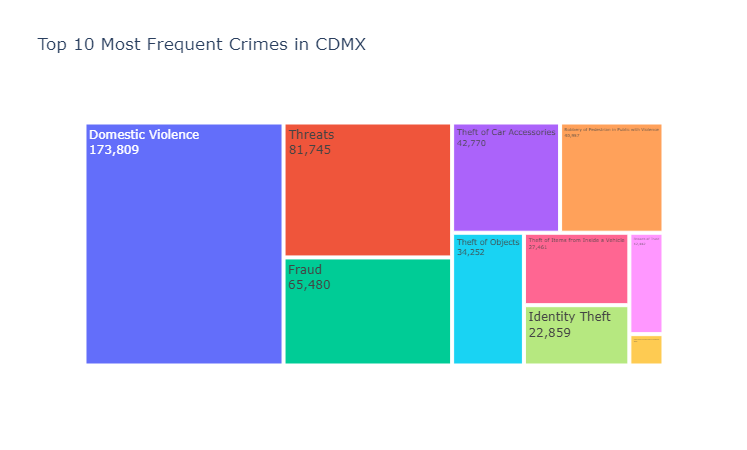

In [12]:
# Plotting the Monthly Crime Trends in the city

# Extracting the year and month for grouping
crime_data['year_month'] = crime_data['incident_date'].dt.to_period('M').dt.to_timestamp()

# Group by year_month and crime to get monthly counts
monthly_counts = crime_data.groupby(['year_month', 'crime']).size().reset_index(name='count')

# Filter data for the years 2019 to 2024
monthly_counts = monthly_counts[(monthly_counts['year_month'] >= '2019-01-01') & (monthly_counts['year_month'] <= '2024-10-31')]


#Plotting the figure
fig = go.Figure()

# Plot each crime type and annotate the maximum point
for crime in monthly_counts['crime'].unique():
    crime_data_subset = monthly_counts[monthly_counts['crime'] == crime]
    
    # Plot the original data line
    fig.add_trace(go.Scatter(
        x=crime_data_subset['year_month'], 
        y=crime_data_subset['count'],
        mode='lines',
        name=crime,
        opacity=0.7
    ))
    
    # Annotate the maximum point for each crime type
    max_point = crime_data_subset.loc[crime_data_subset['count'].idxmax()]
    fig.add_annotation(
        x=max_point['year_month'],
        y=max_point['count'],
        text=f"{max_point['count']}",
        showarrow=True,
        arrowhead=3,
        ax=0,
        ay=-40
    )

# We update the figure to adjust the graph
max_count = monthly_counts['count'].max() * 1.2 
fig.update_layout(
    title='Monthly Crime Trends by Type in CDMX',
    xaxis_title='Year-Month',
    yaxis_title='Number of Incidents',
    legend_title='Crime Type',
    xaxis_tickangle=-45,
    yaxis=dict(range=[0, max_count])  # Adjust y-axis range to make it larger
)

# Show the figure
fig.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

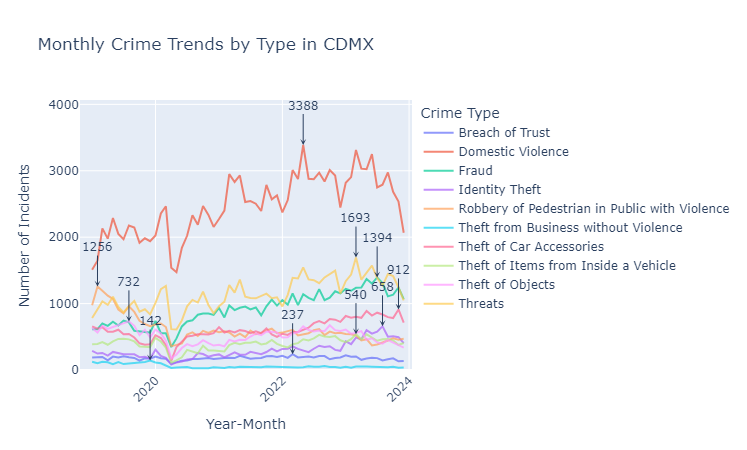

In [13]:
# Plotting evolution of Monthly Crime trends

# Grouping by year_month and incident borough
borough_trends = crime_data.groupby(['year_month', 'incident_borough']).size().reset_index(name='count')

fig = px.line(borough_trends, x='year_month', y='count', color='incident_borough', title='Monthly Crime Trends by Borough')

# Update layout and set x-axis range
fig.update_layout(
    xaxis_title='Year-Month',
    yaxis_title='Number of Incidents'
)

fig.update_xaxes(range=['2019-01-01', '2024-10-31'])

fig.show()



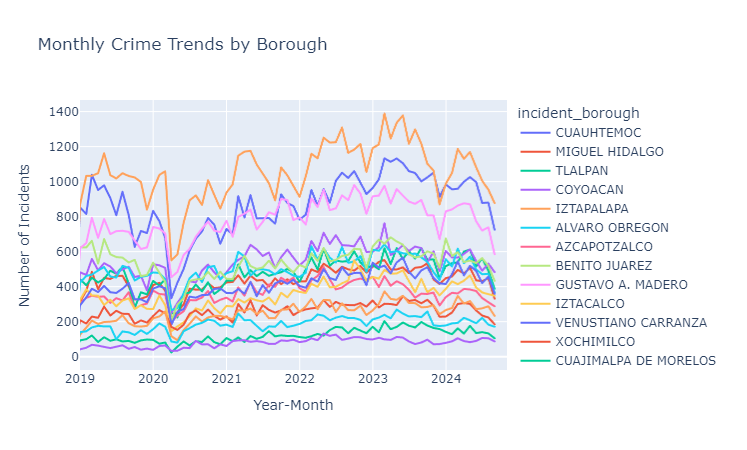

*Analyzing crime trends by gender*

In [14]:
crime_data['year_month'] = pd.to_datetime(crime_data['incident_date']).dt.to_period('M').dt.to_timestamp()
gender_trends = crime_data.groupby(['year_month', 'gender']).size().reset_index(name='count')

fig = px.line(gender_trends, x='year_month', y='count', color='gender', title='Monthly Crime Trends by Gender')
fig.update_xaxes(range=['2019-01-01', '2024-09-30'])
fig.update_layout(xaxis_title='Year-Month', yaxis_title='Number of Incidents')
# Annotate the maximum points for each gender
for gender in gender_trends['gender'].unique():
    gender_data = gender_trends[gender_trends['gender'] == gender]
    max_point = gender_data.loc[gender_data['count'].idxmax()]
    fig.add_annotation(
        x=max_point['year_month'],
        y=max_point['count'],
        text=f"{max_point['count']}",
        showarrow=True,
        arrowhead=3,
        ax=0,
        ay=-15
    )

fig.show()


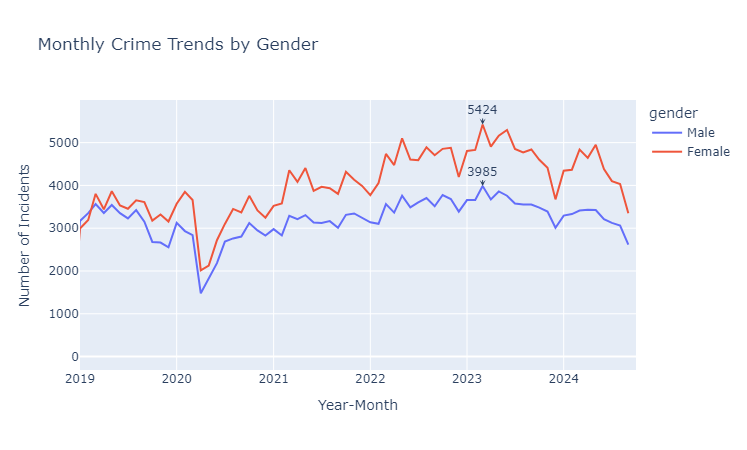

In [15]:
#Plotting Crime type distribution by gender

gender_crime_distribution = crime_data.groupby(['crime', 'gender']).size().reset_index(name='count')

fig = px.bar(gender_crime_distribution, x='crime', y='count', color='gender', title='Crime Type Distribution by Gender')
fig.update_layout(xaxis_title='Crime Type', yaxis_title='Count of Incidents', barmode='stack')
fig.show()


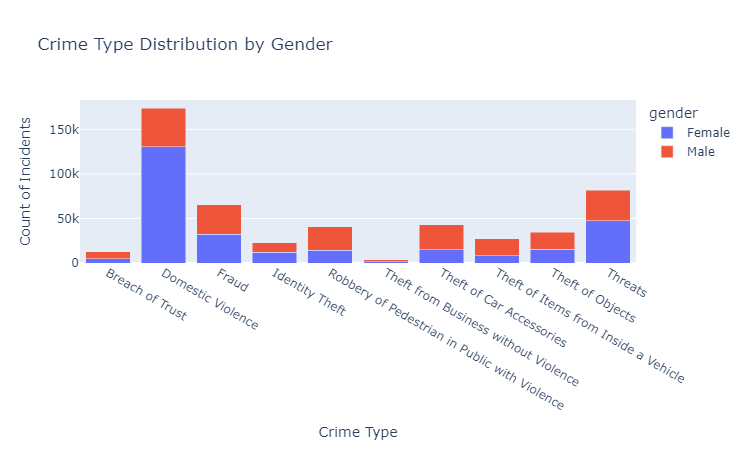

In [16]:
# Plotting Incidents by Gender and Day of the Week

# Group data by day of the week and gender the calculate the count
day_gender_counts = crime_data.groupby(['day_of_week', 'gender']).size().reset_index(name='count')

# Create a grouped bar plot
fig = px.bar(day_gender_counts, x='day_of_week', y='count', color='gender', 
             title='Incidents by Gender and Day of the Week', barmode='group')

# Update axis labels
fig.update_layout(xaxis_title='Day of the Week', yaxis_title='Number of Incidents')
fig.show()



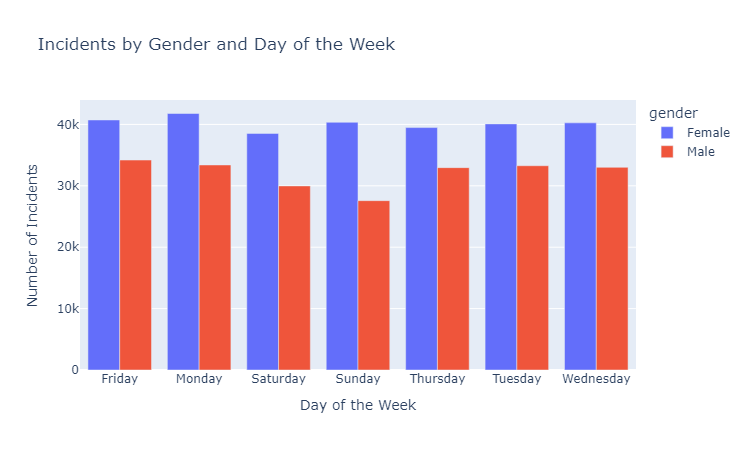

In [17]:
# Plotting Crime Rate by Borough and Gender

# Group data by borough and gender, then calculate the count
borough_gender_counts = crime_data.groupby(['incident_borough', 'gender']).size().reset_index(name='count')

# Create a grouped bar plot
fig = px.bar(borough_gender_counts, x='incident_borough', y='count', color='gender', 
             title='Crime Rate by Borough and Gender', barmode='group')

# Update axis labels
fig.update_layout(xaxis_title='Borough', yaxis_title='Number of Incidents')
fig.show()

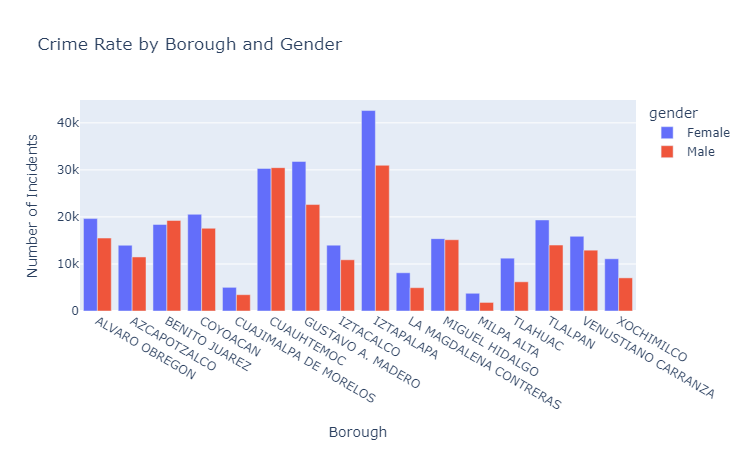

In [18]:
# Plotting Crime Rate by Borough and Gender

# Group data by borough and gender, then calculate the count
borough_gender_counts = crime_data.groupby(['incident_borough', 'crime']).size().reset_index(name='count')

# Create a grouped bar plot
fig = px.bar(borough_gender_counts, x='incident_borough', y='count', color='crime', 
             title='Crime Rate by Borough and Gender', barmode='group')

# Update axis labels and set y-axis range
fig.update_layout(xaxis_title='Borough', yaxis_title='Number of Incidents')
fig.update_yaxes(range=[0, 15000])  # Set y-axis range up to just under 15,000

fig.show()


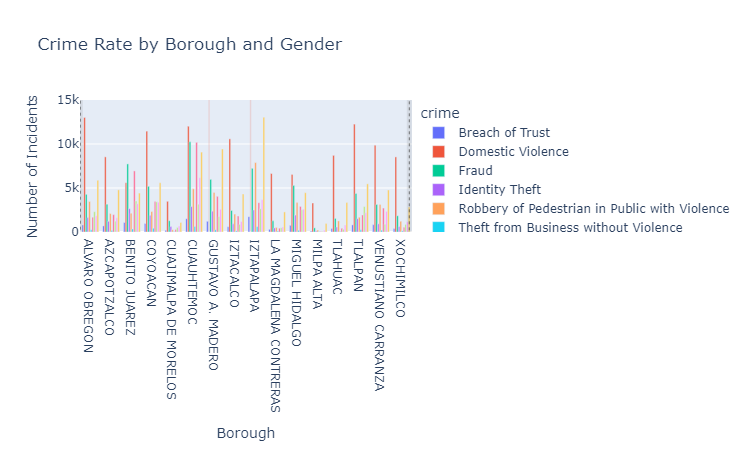

## Modeling - Clustering Analysis for 2024
**Methodology**:
**Clustering Technique**: K-Means clustering was selected due to its efficiency in partitioning data based on spatial and categorical similarities, allowing for distinct groupings of crime incidents.

Identify Patterns: Group similar types of crime incidents based on characteristics such as location, crime type, and frequency. Clustering reveals hidden patterns that can help authorities understand which types of crimes are concentrated in specific areas and times.

**Support Targeted Interventions**: By recognizing patterns within each cluster (e.g., high rates of vehicle theft in commercial zones or domestic violence in residential areas), clustering allows for tailored responses. Law enforcement can focus resources on specific regions and crime types, making prevention efforts more effective.

**Optimize Resource Allocation**: Clustering reveals crime "hotspots" and areas with high crime diversity, allowing authorities to allocate resources (patrols, surveillance) to areas most in need, while ensuring public safety.

**Guide Policy and Community Programs**: Insights from clusters can inform the development of community programs (e.g., financial literacy in fraud-prone areas) and influence policy decisions tailored to the needs of each region.

**Enhance Predictive Analysis**: Clusters provide a basis for future predictive analysis, enabling law enforcement to anticipate crime trends and take proactive steps in high-risk areas.


**Variables selected for clustering**
* Crime: Understanding what types of crimes are more prevalent.
* Location: Identifying specific boroughs and hotspots where crimes are more likely to occur.
* Time (day of the week): Recognizing weekly patterns in crime, which supports temporal resource planning.

By clustering with these features, we can derive insights into how crime types, locations, and temporal factors intersect, providing a foundation for targeted crime prevention strategies in Mexico City.

In [27]:
# Filter the data to only include records from 2024
crime_data_2024 = crime_data[crime_data['incident_year'] == 2024]

In [29]:

# Select relevant features for clustering
data = crime_data_2024[['crime', 'incident_borough', 'latitude', 'longitude', 'day_of_week']]

# Encode categorical variables
label_encoders = {}
for column in ['crime', 'incident_borough', 'day_of_week']:
    le = LabelEncoder()
    le.fit(crime_data_2024[column])  # Fit on the full data to capture all possible categories
    data[column] = le.transform(data[column])  # Encode selected data for clustering
    label_encoders[column] = le


# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


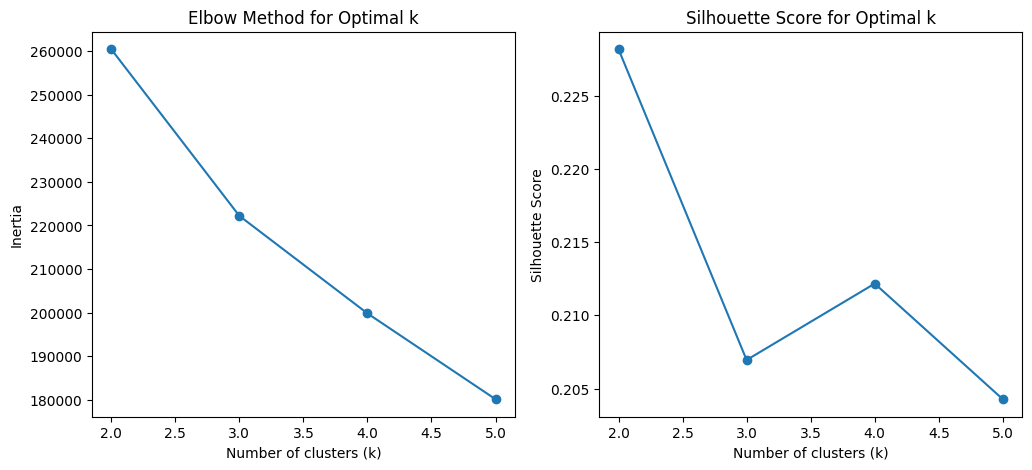

In [30]:

# Determinign the optimal number of clusters using the elbow method
inertia = []
sil_scores = []
range_n_clusters = range(2, 6)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(scaled_data, kmeans.labels_))

plt.figure(figsize=(12, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.show()


In [35]:
optimal_k = 3  # based on the graph we did before
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster'] = kmeans.fit_predict(scaled_data)

# Analyze clusters
clustered_data = pd.concat([crime_data_2024[['crime', 'incident_borough', 'latitude', 'longitude']], data['cluster']], axis=1)
clustered_data.head(10)


crime incident_borough  \
433311  Robbery of Pedestrian in Public with Violence         COYOACAN   
433313                       Theft of Car Accessories       CUAUHTEMOC   
433314                                        Threats          TLALPAN   
433316  Robbery of Pedestrian in Public with Violence          TLAHUAC   
433317           Theft of Items from Inside a Vehicle       IZTAPALAPA   
433318           Theft of Items from Inside a Vehicle   MIGUEL HIDALGO   
433319                                        Threats          TLAHUAC   
433320                       Theft of Car Accessories        IZTACALCO   
433326                               Theft of Objects          TLALPAN   
433328                                          Fraud    BENITO JUAREZ   

         latitude  longitude  cluster  
433311  19.321407 -99.172310        2  
433313  19.406539 -99.127682        0  
433314  19.232057 -99.213163        1  
433316  19.288396 -99.053909        1  
433317  19.323027 -99.100824        0  
433318  19.405571 -99.196361        0  
433319  19.291012 -99.052771        1  
433320  19.396460 -99.128669        0  
433326  19.225335 -99.211645        1  
433328  19.386536 -99.164312        2

In [36]:

# Lets pre charge the coordinates for Mexico City
map_clusters = folium.Map(location=[19.4326, -99.1332], zoom_start=10)

# colors for each of the four clusters
colors = ['red', 'blue', 'green', 'purple']
color_mapping = {i: colors[i % len(colors)] for i in clustered_data['cluster'].unique()}

# Add separate layers for each cluster with markers
for cluster_num in clustered_data['cluster'].unique():
    cluster_layer = folium.FeatureGroup(name=f'Cluster {cluster_num + 1}')
    cluster_data = clustered_data[clustered_data['cluster'] == cluster_num]
    marker_cluster = MarkerCluster().add_to(cluster_layer)
    
    for _, row in cluster_data.iterrows():
        if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
            folium.Marker(
                location=[row['latitude'], row['longitude']],
                popup=f"Crime: {row['crime']}<br>Borough: {row['incident_borough']}",
                icon=folium.Icon(color=color_mapping[cluster_num])
            ).add_to(marker_cluster)
        
    cluster_layer.add_to(map_clusters)

# Add a heatmap layer
heatmap_layer = folium.FeatureGroup(name='Crime Heatmap')
heatmap_data = [[row['latitude'], row['longitude']] for _, row in clustered_data.iterrows() if pd.notnull(row['latitude']) and pd.notnull(row['longitude'])]
HeatMap(heatmap_data, radius=10).add_to(heatmap_layer)
heatmap_layer.add_to(map_clusters)

# Add layer control to toggle each cluster layer and heatmap visibility
folium.LayerControl().add_to(map_clusters)

# Save the map to an HTML file
map_clusters.save("cdmx_crime_clusters_mapping.html")

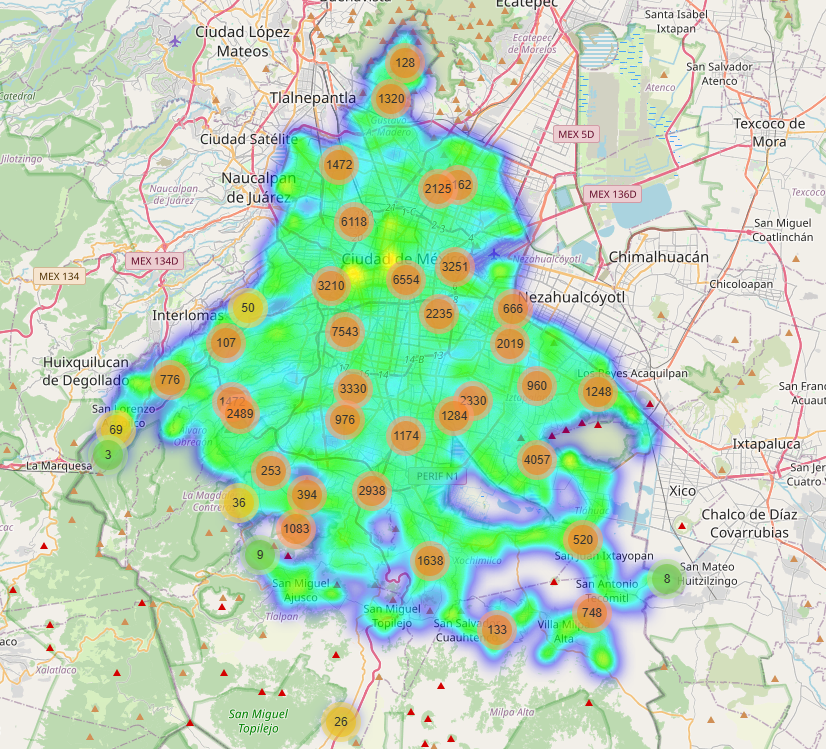
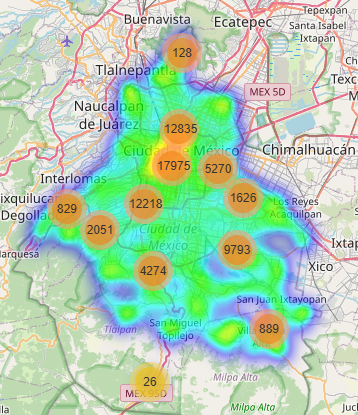

## Model Conclusion - Analyzing the clustered Data

In [37]:

# Step 1: Overall Crime Distribution by Cluster
cluster_counts = clustered_data['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']
overall_cluster_dist_plot = px.bar(cluster_counts, x='cluster', y='count', color='cluster',
                                   title="Overall Crime Distribution by Cluster",
                                   labels={'count': 'Total Crime Count', 'cluster': 'Cluster'},
                                   height=500)

# Step 3: Heatmap of Crime Types by Borough
# This shows the association between boroughs and specific crime types across clusters
crime_borough_counts = clustered_data.groupby(['incident_borough', 'crime']).size().reset_index(name='count')
heatmap_plot = px.density_heatmap(crime_borough_counts, x='incident_borough', y='crime', z='count', 
                                  title="Heatmap of Crime Types by Borough",
                                  labels={'count': 'Crime Count', 'incident_borough': 'Borough', 'crime': 'Crime Type'},
                                  height=700)

# Display the plots
overall_cluster_dist_plot.show()
heatmap_plot.show()


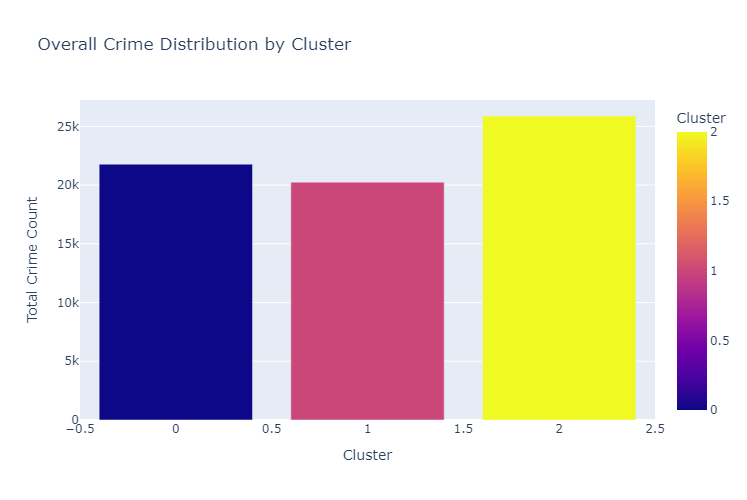



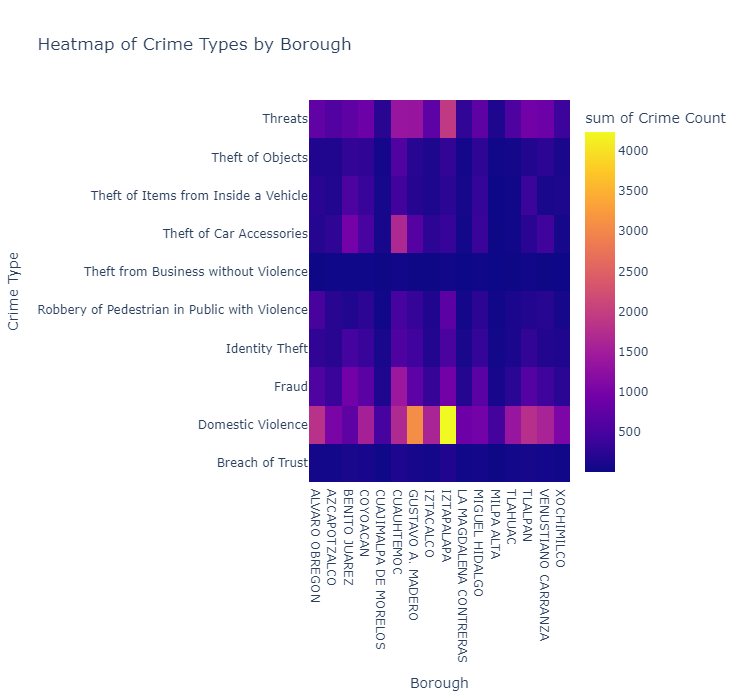

In [38]:

# Crime Type Distribution for Cluster 0
cluster_0_data = clustered_data[clustered_data['cluster'] == 0]
cluster_0_crime_dist_plot = px.histogram(cluster_0_data, x='crime', color='crime',
                                         title="Crime Distribution for Cluster 0",
                                         labels={'count': 'Crime Count', 'crime': 'Crime Type'},
                                         height=500)

# Crime Type Distribution for Cluster 1
cluster_1_data = clustered_data[clustered_data['cluster'] == 1]
cluster_1_crime_dist_plot = px.histogram(cluster_1_data, x='crime', color='crime',
                                         title="Crime Distribution for Cluster 1",
                                         labels={'count': 'Crime Count', 'crime': 'Crime Type'},
                                         height=500)

# crime Type Distribution for Cluster 2
cluster_2_data = clustered_data[clustered_data['cluster'] == 2]
cluster_2_crime_dist_plot = px.histogram(cluster_2_data, x='crime', color='crime',
                                         title="Crime Distribution for Cluster 2",
                                         labels={'count': 'Crime Count', 'crime': 'Crime Type'},
                                         height=500)

# Borough Distribution for Each Cluster
borough_cluster_dist_plot = px.histogram(clustered_data, x='incident_borough', color='cluster', barmode='group',
                                         title="Incident Borough Distribution by Cluster",
                                         labels={'count': 'Incident Count', 'incident_borough': 'Borough'},
                                         height=500)

# Plot in the same space
cluster_0_crime_dist_plot.show()
cluster_1_crime_dist_plot.show()
cluster_2_crime_dist_plot.show()
borough_cluster_dist_plot.show()


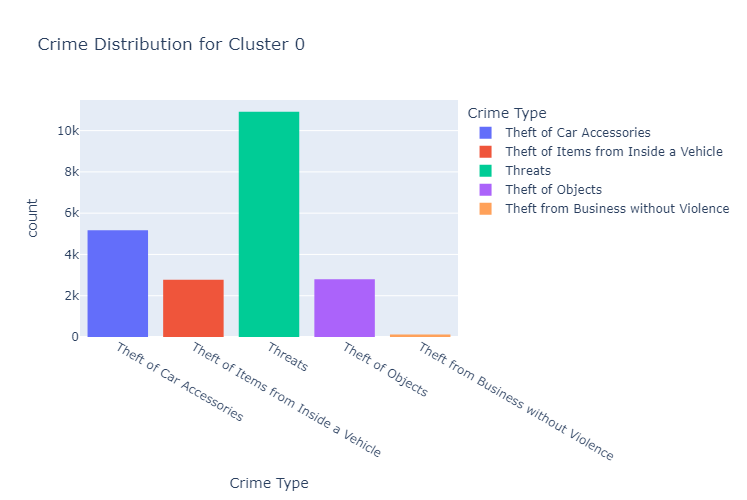

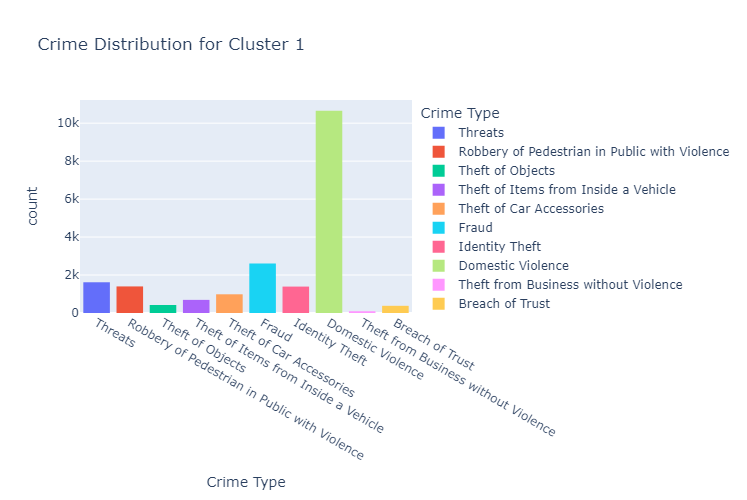

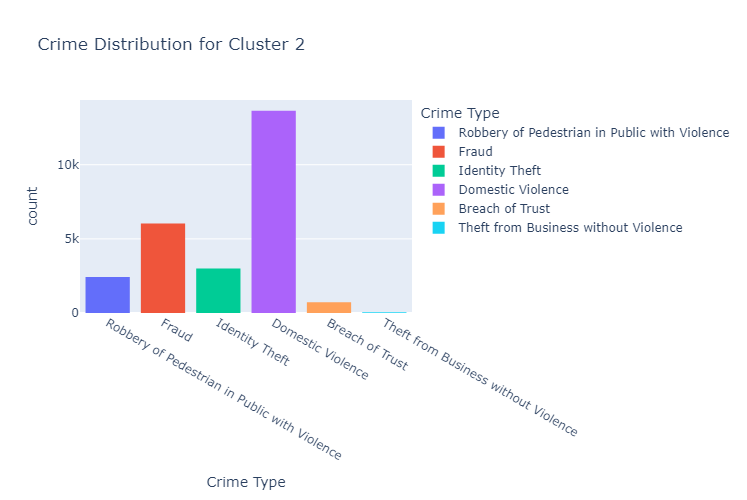


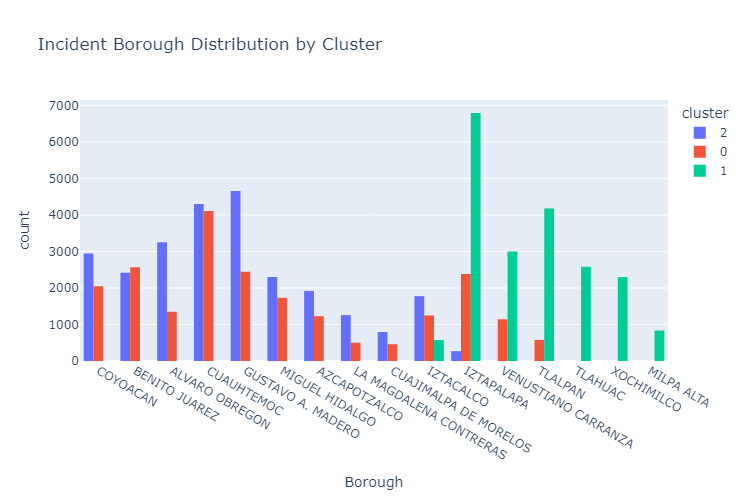



**Cluster 0**: This cluster is primarily associated with Theft of Car Accessories, Theft of Items from Inside a Vehicle, and Threats, as well as a notable presence of Theft of Objects. The high frequency of vehicle-related thefts and threats indicates that Cluster 0 focuses on property crimes and personal intimidation incidents. Geographically, this cluster appears most prominently in Cuauhtémoc, Benito Juárez, Miguel Hidalgo, and Álvaro Obregón—boroughs with high commercial and residential activity. This pattern suggests that vehicle-related and property crimes in these areas may be driven by accessibility to densely populated public spaces, making unattended vehicles and personal belongings vulnerable to theft.

**Cluster 1**: Dominated by Domestic Violence and Threats, with a significant number of Fraud and Identity Theft cases. This cluster appears to focus on crimes that have a personal or domestic impact, potentially arising from socio-economic challenges or interpersonal disputes. Notably high concentrations of incidents in Iztapalapa, Tláhuac, Venustiano Carranza, and Xochimilco support the notion that Cluster 1 is associated with residential areas where social and economic factors may contribute to increased instances of domestic and interpersonal crimes. The presence of fraud and identity theft also suggests that residents in these areas may be vulnerable to financial crimes, possibly due to limited access to financial education or digital literacy resources.

**Cluster 2**: This cluster has a diverse range of crimes, with high occurrences of Domestic Violence, Fraud, Theft from Businesses, and Robbery of Pedestrians in Public. The mixture of crimes in Cluster 2 suggests that it represents areas with varied social and economic activities, accommodating both personal crimes and crimes that occur in public settings. The boroughs associated with this cluster, such as Gustavo A. Madero, Cuauhtémoc, and Coyoacán, are characterized by both residential and commercial zones, where increased foot traffic and economic transactions may expose individuals to crimes like public robbery and fraud.

**Geographic Patterns by Borough**:
Commercial and Densely Populated Areas (e.g., Cuauhtémoc, Benito Juárez, Miguel Hidalgo): High incidences of property crimes and vehicle thefts, as seen in Cluster 0.


Residential Areas with Socioeconomic Vulnerabilities (e.g., Iztapalapa, Tláhuac, Venustiano Carranza): More prevalent personal crimes, such as domestic violence and threats, in Cluster 1.

Mixed-Use Areas with Diverse Crime Profiles (e.g., Gustavo A. Madero, Coyoacán): A mix of crimes in public and private spaces, with public robberies and fraud being frequent in Cluster 2.

## Final conclusion for Security Strategy Improvement
Deploy Targeted Surveillance in Commercial and High-Density Areas:

Increase visible police presence and surveillance systems (e.g., CCTV) in boroughs like Cuauhtémoc, Benito Juárez, and Miguel Hidalgo, where property crimes such as vehicle and accessory theft are prevalent.
Implement mobile patrols and partner with local businesses to create a network of vigilance that deters opportunistic property crimes.
Establish Community Support and Education Programs in Vulnerable Residential Areas:

Develop programs in areas like Iztapalapa, Tláhuac, and Venustiano Carranza focused on reducing domestic violence, providing mental health resources, and promoting financial literacy to mitigate vulnerabilities to fraud and identity theft.
Engage local communities through workshops and support groups aimed at conflict resolution, social services access, and digital safety practices.
Strengthen Public Safety Measures in Mixed-Use Zones:

Enhance street lighting, install emergency call points, and increase foot patrols in boroughs such as Gustavo A. Madero and Coyoacán, where varied crime types, including public robberies, have been identified.
Collaborate with local councils to improve public infrastructure, especially in areas with high foot traffic, to reduce the likelihood of robberies and other opportunistic crimes.
Optimize Resource Allocation Using Cluster-Specific Insights:

Develop a responsive resource allocation plan that focuses on providing additional law enforcement in areas with high property crime rates, social services in vulnerable residential zones, and public safety infrastructure in mixed-use districts.
Regularly review and update resource deployment strategies based on updated crime data and emerging trends to maintain a proactive approach to crime prevention.
Establish Partnerships with Local Organizations:

Form partnerships with non-profits, community organizations, and local government agencies to ensure comprehensive support tailored to each cluster’s specific needs, fostering a safer and more resilient community network.

**These following mission will ensure a strategic, focused approach to enhancing security and community resilience, aligning resources and interventions with the unique crime dynamics across CDMX.**